### **RQ1. Does support for climate policies (like carbon taxes or emissions standards) change during elections? And is this support influenced by personal or community-level perceptions of climate harm?**

To investigate this question, we estimate a **reduced Panel VAR(1)** system focusing on two dependent variables: `cc_pol_tax` (support for carbon taxes) and `cc_pol_car` (support for emissions standards). Each equation includes as predictors the **lagged values** of 17 time-varying variables (including harm perceptions, willingness to pay, policy support, political identity, and demographic covariates) along with a dummy variable for Wave 3 to directly test for election-period effects.

- **Harm perceptions**: `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`  
- **Willingness to pay**: `ccSolve`  
- **Climate policy support**: `cc_pol_tax`, `cc_pol_car` (included as predictors across equations to capture cross-policy influence)  
- **Political identity**: `pol_score`, `pol_ideology` — both treated as categorical variables 
- **Demographic covariates**: `dem_income_binary`, `dem_educ_binary`, `dem_age`, `dem_male_binary` — treated as ordinal or binary numeric variables
- **Election-period control**: `wave3_dummy` — a binary variable coded 1 for Wave 3 (election wave), and 0 otherwise

The following system of two equations is estimated:

$$
\begin{cases}
\text{cc\_pol\_tax}_t = \alpha_1 + \sum_{j=1}^{17} \beta_{1j} \cdot X_{j,t-1} + \theta_1 \cdot \text{wave3\_dummy}_t + \epsilon_{1t} \\
\text{cc\_pol\_car}_t = \alpha_2 + \sum_{j=1}^{17} \beta_{2j} \cdot X_{j,t-1} + \theta_2 \cdot \text{wave3\_dummy}_t + \epsilon_{2t}
\end{cases}
$$

Where:

- $ X_{j,t-1} $ denotes the value of the $ j $-th predictor at time $ t-1 $  
- `wave3_dummy_t` indicates whether the observation corresponds to the election period  
- $ \alpha_i $ is the intercept for equation $ i $  
- $ \beta_{ij} $ is the coefficient for the effect of predictor $ j $ on outcome $ i $  
- $ \epsilon_{it} $ is the idiosyncratic error term, clustered at the respondent level

The dependent variables, `cc_pol_tax_t` and `cc_pol_car_t`, represent support for carbon taxes and emissions standards at time $ t $, respectively. The inclusion of `wave3_dummy` allows us to explicitly test whether **policy support shifted during the election period**, above and beyond dynamics captured by attitudinal or demographic trends. All variables are treated as **jointly endogenous**, and the model is estimated using **pooled OLS** with **clustered standard errors by respondent** (`PID`), based on 1,722 complete observations from three survey waves.

In [17]:
import pandas as pd

# Load dataset
data = pd.read_csv("../data/5-cleaned_data_3waves.csv", low_memory=False)

# Categorize pol_score into broad party-aligned groups
# Democrat -> -2
# Independent, leaning democrat -> -1  
# Independent, leaningn neither -> 0  
# Independent, leaning republican -> 1  
# Republican -> 2
data['party_democrat'] = data['pol_score'].apply(lambda x: 1 if x == -2 else 0)
data['party_republican'] = data['pol_score'].apply(lambda x: 1 if x == 2 else 0)
data['party_independent'] = data['pol_score'].apply(lambda x: 1 if x in [-1, 0, 1] else 0)

# Recategorize pol_ideology
data['ideology_liberal'] = data['pol_ideology'].apply(lambda x: 1 if x >= 4 else 0)
data['ideology_conservative'] = data['pol_ideology'].apply(lambda x: 1 if x <= 2 else 0)
data['ideology_moderate'] = data['pol_ideology'].apply(lambda x: 1 if x == 3 else 0)

print("Manual dummy variables created for pol_party and pol_ideology.")

Manual dummy variables created for pol_party and pol_ideology.


In [18]:
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Define continuous/ordinal predictors
continuous_predictors = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income_binary", "dem_age", "dem_educ_binary", "dem_male_binary"
]

# Dummy predictors created earlier
dummy_predictors = [
    "party_democrat", "party_republican", "party_independent",
    "ideology_liberal", "ideology_conservative", "ideology_moderate"
]

# Election-period dummy
wave_dummy = ["wave3_dummy"]

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions
for var in continuous_predictors + dummy_predictors:
    data[f"{var}_lag"] = data.groupby('PID')[var].shift(1)

# Create wave3_dummy
data["wave3_dummy"] = (data["WAVE"] == 3).astype(int)

# Combine all lagged vars
lagged_vars = [f"{var}_lag" for var in continuous_predictors + dummy_predictors]
all_predictors = lagged_vars + wave_dummy

# Drop missing rows
panel_var_data = data.dropna(subset=lagged_vars)

# --- Model 1: cc_pol_tax_t
X1 = panel_var_data[all_predictors]
y1 = panel_var_data["cc_pol_tax"]
X1 = sm.add_constant(X1)
model1 = sm.OLS(y1, X1).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# --- Model 2: cc_pol_car_t
X2 = panel_var_data[all_predictors]
y2 = panel_var_data["cc_pol_car"]
X2 = sm.add_constant(X2)
model2 = sm.OLS(y2, X2).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output
print(summary_col(
    [model1, model2],
    stars=True,
    model_names=["cc_pol_tax_t", "cc_pol_car_t"],
    info_dict={"N": lambda x: f"{int(x.nobs)}"}
))


                          cc_pol_tax_t cc_pol_car_t
---------------------------------------------------
const                     0.3972***    0.5163***   
                          (0.0760)     (0.0785)    
cc4_world_lag             0.1859***    0.1560***   
                          (0.0306)     (0.0296)    
cc4_wealthUS_lag          -0.0469*     -0.0526**   
                          (0.0252)     (0.0221)    
cc4_poorUS_lag            0.0612**     0.0979***   
                          (0.0301)     (0.0300)    
cc4_comm_lag              -0.0239      0.0037      
                          (0.0365)     (0.0332)    
cc4_famheal_lag           0.0008       0.0026      
                          (0.0348)     (0.0307)    
cc4_famecon_lag           0.0188       -0.0180     
                          (0.0255)     (0.0230)    
ccSolve_lag               0.0907***    0.0193      
                          (0.0224)     (0.0191)    
cc_pol_tax_lag            0.3496***    0.1003***   
           

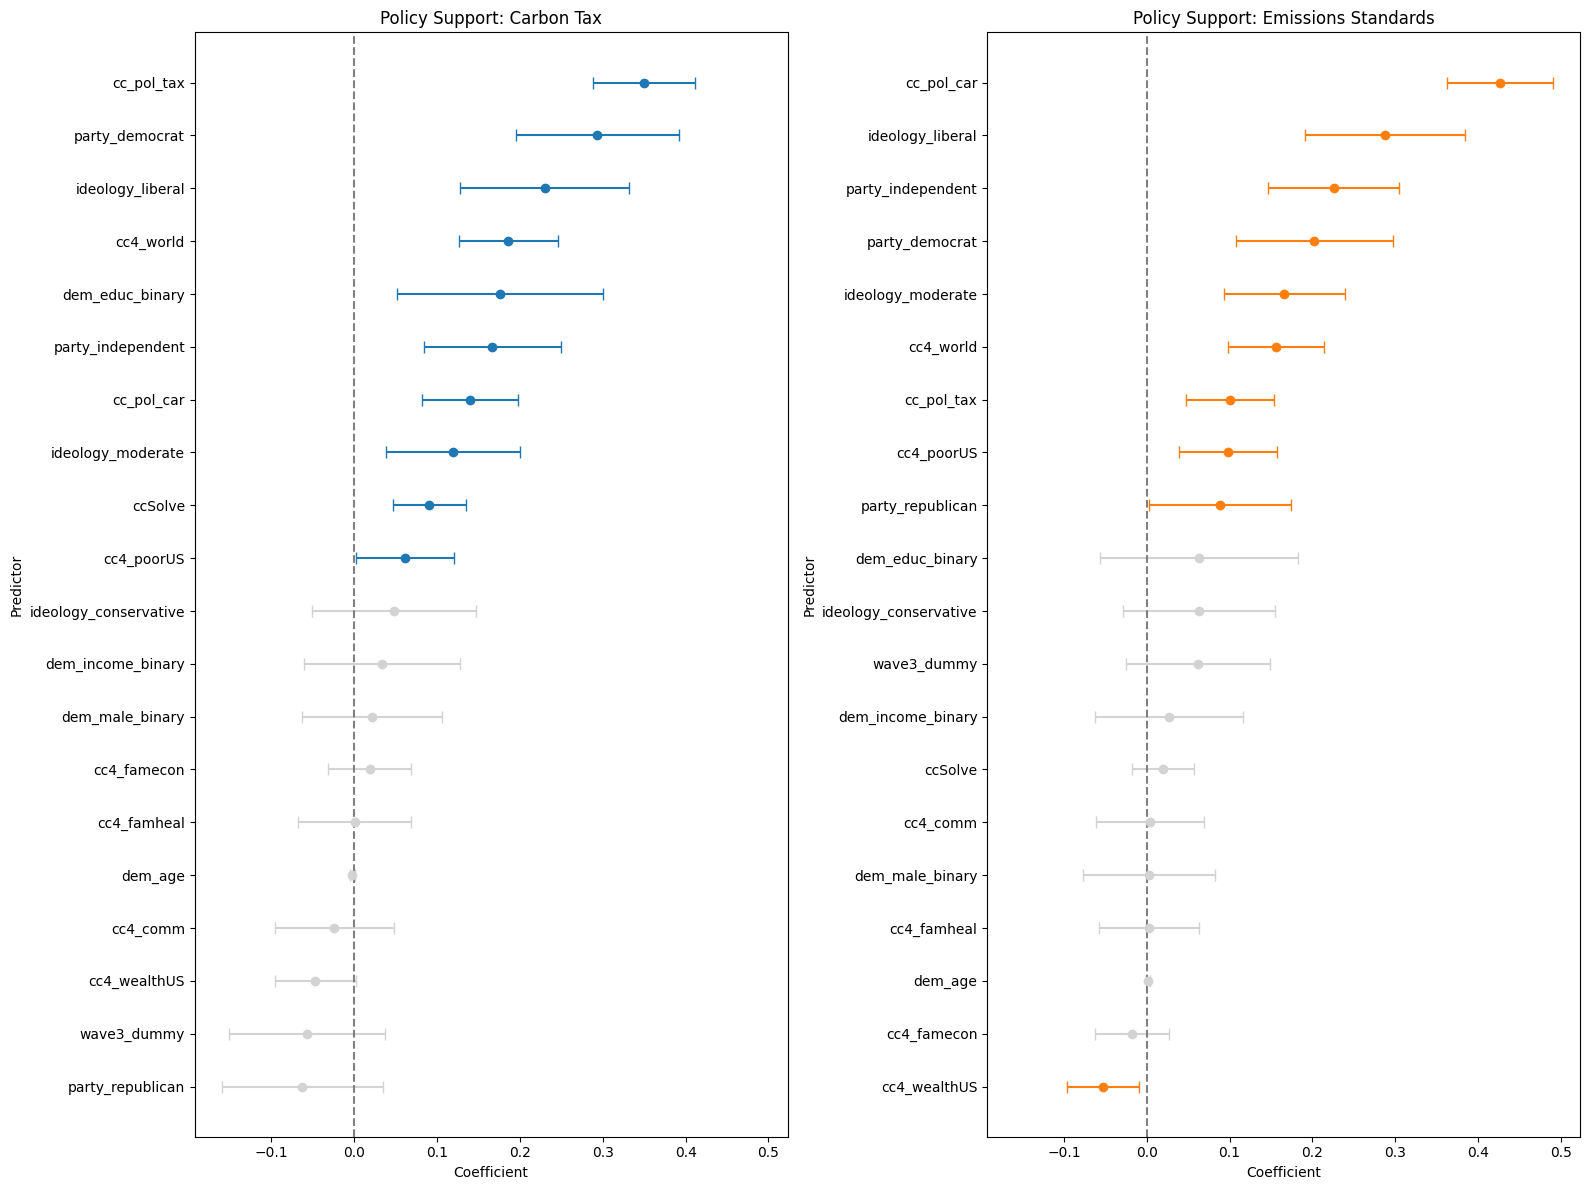

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function
def extract_model_info(model, label):
    coefs = model.params
    conf = model.conf_int()
    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values,
        'model': label
    }).query("predictor != 'const'")
    df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    return df.sort_values(by='coef', ascending=True)

# --- Extract separately
df_tax = extract_model_info(model1, "cc_pol_tax_t")
df_car = extract_model_info(model2, "cc_pol_car_t")

# --- Plotting
fig, axs = plt.subplots(1, 2, figsize=(16, 12), sharex=True)

for ax, df, title, color in zip(
    axs,
    [df_tax, df_car],
    ["Policy Support: Carbon Tax", "Policy Support: Emissions Standards"],
    ["tab:blue", "tab:orange"]
):
    for _, row in df.iterrows():
        plot_color = color if row['significant'] else 'lightgray'
        ax.errorbar(
            row['coef'],
            row['predictor'],
            xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
            fmt='o',
            color=plot_color,
            ecolor=plot_color,
            capsize=4
        )
    ax.axvline(0, color='gray', linestyle='--')
    ax.set_title(title)
    ax.set_xlabel("Coefficient")
    ax.set_ylabel("Predictor")

plt.tight_layout()
plt.savefig("../results/rq1_dot_whisker_policy_support.png", dpi=300)
plt.show()

> **Interpreting a Dot-Whisker Plot**  
> A **dot-whisker plot** visualizes the results of regression models (or similar estimates) by showing each variable's estimated effect and the uncertainty around it.
> - **Dots** represent **point estimates** (e.g., regression coefficients)
>   - Each dot shows the estimated impact of a predictor variable on the outcome
> - **Whiskers (horizontal lines)** represent the **confidence intervals** around the point estimates
>   - Most often, these are **95% confidence intervals**
>   - The wider the whisker, the greater the uncertainty in the estimate
> - A **vertical line at zero** (often shown) indicates **no effect**
>   - If a whisker **crosses zero**, the estimate is **not statistically significant** at the 95% level
>   - If it **does not cross zero**, the effect is considered **statistically significant**
> 
> This type of plot is useful for quickly comparing multiple predictors and identifying which ones have a clear, statistically significant relationship with the outcome
> 
> **Note:** Coefficients are sorted by their signed value (not absolute size) to reflect both magnitude (how strong) and direction of effect (positive or negative). Predictors whose 95% confidence intervals include zero (that are not statistically significant) are displayed in gray. This helps focus attention on the variables that clearly have an effect.
> 
> **Why not use absolute coefficients?**
> Sorting by absolute coefficient size would show the predictors with the strongest effects first, regardless of whether those effects are positive or negative. However, in this analysis, we wanted to highlight **the direction** of each effect (e.g., does it increase or decrease support?). That’s why we sorted by the raw coefficient values - so variables that reduce support appear on one side of the plot, and those that increase it appear on the other.

#### Panel VAR Analysis – RQ1  
The results show that **support for both carbon taxes and emissions standards remains stable over time**, with **no significant shift during the election period**, as indicated by the non-significant `wave3_dummy`. Instead, support is more strongly associated with **climate concern, political alignment, and education level** - though only some of these effects reach statistical significance.

Key findings:
* **Previous support** is the strongest and most consistent predictor for both policy types, confirming temporal persistence.
* **Democratic party affiliation**, **liberal ideology**, and **global climate harm perception** are significantly associated with increased support for both carbon taxes and emissions standards.
* **Concern for poor U.S. communities** also has a significant and positive effect, particularly for emissions standards.
* **Higher education** is positively associated with carbon tax support but not statistically significant for emissions standards.
* **Willingness to pay** (`ccSolve`) is positively linked to support for carbon taxes but has no significant effect on emissions standards.
* **Republican affiliation** shows a negative association with carbon tax support (though not statistically significant), while its relationship with emissions standards is more complex and not consistently significant.
* **Independents** show modest but significant positive associations with both types of climate policy, suggesting bipartisan appeal for regulatory measures.
* **No significant effect** is detected for the `wave3_dummy`, indicating that support did **not shift noticeably during the election period**.
* For **emissions standards support (`cc_pol_car_t`)**, `cc4_wealthUS` has a **small but statistically significant negative coefficient**. This suggests that **greater concern for wealthy U.S. communities is associated with slightly *lower* support** for emissions regulations.

> Therefore, the answer to RQ1 is **No**:  
> There is **no election-related shock** in climate policy support. Instead, **support patterns reflect long-term political identity and climate concern**, rather than short-term political events.

In [20]:
import plotly.graph_objects as go
import networkx as nx
import os
os.makedirs("../results", exist_ok=True)

edges_tax = df_tax[df_tax['significant']][['predictor', 'model', 'coef']].copy()
edges_tax.columns = ['source', 'target', 'weight']

edges_car = df_car[df_car['significant']][['predictor', 'model', 'coef']].copy()
edges_car.columns = ['source', 'target', 'weight']

# Build graph
G = nx.DiGraph()
for _, row in edges_tax.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

pos = nx.spring_layout(G, seed=42)

# Extract positions and edges
edge_x, edge_y, edge_widths = [], [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_widths.append(abs(G[u][v]['weight']) * 4)  # scale for visibility

# Plot edges
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
))

# Plot nodes
node_x, node_y = zip(*[pos[n] for n in G.nodes()])
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    marker=dict(size=30, color='blue'),
    hoverinfo='text'
))

fig.update_layout(
    showlegend=False,
    title="Interactive VAR Graph (cc_pol_tax)",
    hovermode='closest'
)
fig.write_html("../results/rq1_var_graph_cc_pol_tax.html")
fig.show()

# Build graph for model2 (cc_pol_car)
G = nx.DiGraph()
for _, row in edges_car.iterrows():
    G.add_edge(row['source'], row['target'], weight=row['weight'])

pos = nx.spring_layout(G, seed=42)

# Extract positions and edges
edge_x, edge_y, edge_widths = [], [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]
    edge_widths.append(abs(G[u][v]['weight']) * 4)  # scaled for visibility

# Plot edges
fig = go.Figure()
fig.add_trace(go.Scatter(
    x=edge_x, y=edge_y,
    mode='lines',
    line=dict(width=1, color='gray'),
    hoverinfo='none'
))

# Plot nodes
node_x, node_y = zip(*[pos[n] for n in G.nodes()])
fig.add_trace(go.Scatter(
    x=node_x,
    y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    marker=dict(size=30, color='orange'),  # Use orange to match dot-whisker color
    hoverinfo='text'
))

fig.update_layout(
    showlegend=False,
    title="Interactive VAR Graph (cc_pol_car)",
    hovermode='closest'
)
fig.write_html("../results/rq1_var_graph_cc_pol_car.html")
fig.show()

---

### **RQ2. Does willingness to pay for climate solutions vary during elections, and what factors influence it?**
To examine how willingness to pay for climate solutions is shaped by broader climate-related attitudes, political identity, and demographic characteristics, we estimate a **reduced Panel VAR(1)** model with `ccSolve_t` (willingness to financially support climate action) as the dependent variable.

The equation includes as predictors the **lagged values** of 17 time-varying variables, grouped as follows:

- **Harm perceptions**:
  - `cc4_world`: perceived harm to the world  
  - `cc4_wealthUS`: harm to wealthy U.S. communities  
  - `cc4_poorUS`: harm to poor U.S. communities  
  - `cc4_comm`: harm to local communities  
  - `cc4_famheal`: harm to family health  
  - `cc4_famecon`: harm to family economic well-being  

- **Policy support**:
  - `cc_pol_tax`: support for carbon taxes  
  - `cc_pol_car`: support for emissions standards  

- **Political identity** (dummy-coded):
  - `party_democrat`, `party_republican`, `party_independent`  
  - `ideology_liberal`, `ideology_conservative`, `ideology_moderate`

- **Demographics** (treated as ordinal or binary):
  - `dem_income_binary`: income level (low vs high)  
  - `dem_age`: respondent's age  
  - `dem_educ_binary`: education level (lower vs higher education)  
  - `dem_male_binary`: gender (male vs female/self-described)

* **Election-period indicator**:

  * `wave3_dummy`: a binary variable equal to 1 if the observation is from Wave 3 (election wave), and 0 otherwise

The full equation is:

$$
\text{ccSolve}_t = \alpha 
+ \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \beta_7 \cdot \text{ccSolve}_{t-1} 
+ \beta_8 \cdot \text{cc\_pol\_tax}_{t-1} 
+ \beta_9 \cdot \text{cc\_pol\_car}_{t-1} 
+ \sum_{k=10}^{13} \gamma_k \cdot D_{k,t-1} 
+ \sum_{l=14}^{19} \delta_l \cdot C_{l,t-1} 
+ \theta \cdot \text{wave3\_dummy} 
+ \epsilon_t
$$

Where:

- $ H_{j,t-1} $ are the six lagged harm perception variables  
- $ D_{k,t-1} $ are the lagged demographic covariates  
- $ C_{l,t-1} $ are the dummy-coded political identity variables  
- `wave3_dummy` explicitly controls for the election period
- $ \alpha $ is the intercept term  
- $ \epsilon_t $ is the individual-level error term (clustered by PID)  

To assess how willingness to pay evolves over time and what factors influence it, we examine the `ccSolve_t` equation within a reduced Panel VAR(1) framework. The model is estimated using pooled OLS with **cluster-robust standard errors at the individual level**, based on 1,722 complete observations across three survey waves. This model allows us to test not only **which factors predict willingness to pay**, but also **whether the election period (Wave 3) has a distinct effect** on these attitudes. The inclusion of `wave3_dummy` makes it possible to isolate short-term shifts during the election from longer-term dynamics in the panel.

In [21]:
import statsmodels.api as sm

# Define variables to be lagged (original + dummies + demographics)
variables = [
    "cc4_world", "cc4_wealthUS", "cc4_poorUS",
    "cc4_comm", "cc4_famheal", "cc4_famecon",
    "ccSolve", "cc_pol_tax", "cc_pol_car",
    "dem_income_binary", "dem_age", "dem_educ_binary", "dem_male_binary",
    "party_democrat", "party_republican", "party_independent",
    "ideology_liberal", "ideology_conservative", "ideology_moderate",
    "wave3_dummy"  # New variable for capturing election-period effect
]

# Create wave3 dummy (1 if wave == 3, else 0)
data['wave3_dummy'] = data['WAVE'].apply(lambda x: 1 if x == 3 else 0)

# Sort by PID and WAVE
data = data.sort_values(by=['PID', 'WAVE'])

# Create lagged versions of all predictors
for var in variables:
    data[f'{var}_lag'] = data.groupby('PID')[var].shift(1)

# Drop missing values
lagged_vars = [f'{v}_lag' for v in variables]
panel_var_data = data.dropna(subset=lagged_vars + ['ccSolve'])

# Estimate the rq2_model: ccSolve_t
X = panel_var_data[lagged_vars]
y = panel_var_data['ccSolve']
X = sm.add_constant(X)
rq2_model = sm.OLS(y, X).fit(cov_type='cluster', cov_kwds={'groups': panel_var_data['PID']})

# Output results
print(rq2_model.summary())

                            OLS Regression Results                            
Dep. Variable:                ccSolve   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.065
Method:                 Least Squares   F-statistic:                     362.2
Date:                Tue, 13 May 2025   Prob (F-statistic):               0.00
Time:                        15:22:46   Log-Likelihood:                -2348.4
No. Observations:                1722   AIC:                             4735.
Df Residuals:                    1703   BIC:                             4838.
Df Model:                          18                                         
Covariance Type:              cluster                                         
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                 

c:\Users\pleivadaros\Documents\msc\msc-thesis\climate-opinions-shift-elections-policies\.venv\Lib\site-packages\statsmodels\base\model.py:1894: ValueWarning:

covariance of constraints does not have full rank. The number of constraints is 20, but rank is 19



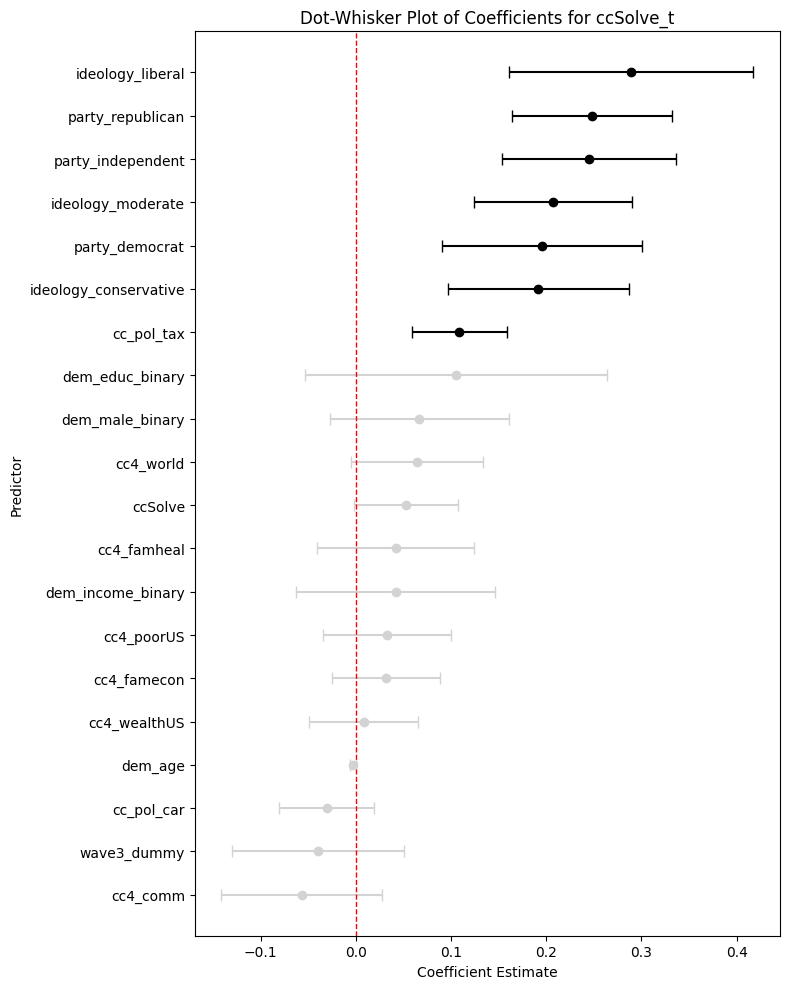

In [22]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Step 1: Extract model coefficients and confidence intervals
def extract_model_info(model):
    coefs = model.params
    conf = model.conf_int()
    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values
    }).query("predictor != 'const'")  # exclude intercept
    # Add significance flag: True if CI does not include zero
    df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))
    return df

# --- Step 2: Extract info and sort predictors
plot_df = extract_model_info(rq2_model)
plot_df['predictor'] = plot_df['predictor'].str.replace('_lag', '', regex=False)
plot_df = plot_df.sort_values(by='coef', ascending=True)

# --- Step 3: Plot
plt.figure(figsize=(8, 10))

for _, row in plot_df.iterrows():
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color='black' if row['significant'] else 'lightgray',
        ecolor='black' if row['significant'] else 'lightgray',
        capsize=4
    )

plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.title("Dot-Whisker Plot of Coefficients for ccSolve_t")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor")
plt.tight_layout()
plt.savefig("../results/rq2_dot_whisker_ccSolve_coefficients.png", dpi=300)
plt.show()

#### Panel VAR Analysis – RQ2 (Willingness to Pay as Outcome)
* **Strongest predictors of increased WTP (`ccSolve_t`)** are:
  * `ideology_liberal`
  * `party_republican`
  * `party_independent`
  * `ideology_moderate`
  * `party_democrat`
  * `ideology_conservative`
  * (also weakly significant: `cc_pol_tax`)
* **Election period dummy (`wave3_dummy`)** is **not statistically significant**, suggesting **no election-period shock** in willingness to pay after controlling for attitudes and identity.
* **Most demographic and harm perception variables (gray lines)** are **not significant**, indicating that **political orientation plays a much stronger role than climate risk perception** in shaping WTP.

> **Therefore, the answer to RQ2 is:**
>
> **Willingness to pay is stable across the election period** and is **primarily influenced by political identity**.  
> Harm perception, demographics, and the election wave itself do **not** significantly alter WTP in this model.

In [23]:
import plotly.graph_objects as go
import networkx as nx
import plotly.io as pio

# Build the directed graph using rq2_model results (significant edges only)
G = nx.DiGraph()

# Extract coefficients and CIs from your actual model
coefs = rq2_model.params
conf_int = rq2_model.conf_int()
significant_edges = []

for predictor in coefs.index:
    if predictor == 'const':
        continue
    lower, upper = conf_int.loc[predictor]
    if lower > 0 or upper < 0:  # significance test
        G.add_edge(predictor, 'ccSolve_t', weight=coefs[predictor])
        significant_edges.append((predictor, coefs[predictor]))

# Generate layout
pos = nx.spring_layout(G, seed=42)

# Extract edge positions
edge_x, edge_y = [], []
for u, v in G.edges():
    x0, y0 = pos[u]
    x1, y1 = pos[v]
    edge_x += [x0, x1, None]
    edge_y += [y0, y1, None]

# Create edge trace
edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line=dict(width=1, color='gray'),
    hoverinfo='none',
    mode='lines'
)

# Create node trace
node_x, node_y = zip(*[pos[n] for n in G.nodes()])
node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text=list(G.nodes()),
    textposition="top center",
    marker=dict(size=30, color='black'),
    hoverinfo='text'
)

# Plot the graph
fig = go.Figure(data=[edge_trace, node_trace])
fig.update_layout(
    title="Interactive VAR Graph (ccSolve_t)",
    showlegend=False,
    hovermode='closest'
)
fig.write_html("../results/rq2_var_graph_cc_Solve.html")
fig.show()

---

### **RQ3. Does political ideology moderate the relationship between perceptions of harm and willingness to pay for climate solutions?**

To address this question, we extend the **Panel VAR(1)** framework by estimating a model where `ccSolve_t` (willingness to financially support climate action) is the dependent variable. Our aim is to test whether the effect of perceived climate harm on willingness to pay differs depending on respondents' political ideology.

Specifically, we include **interaction terms between ideology indicators and harm perception variables**. This allows us to assess whether the strength or direction of these effects varies across ideological groups. The model includes the lagged values of all predictors and an indicator variable for the election wave.

* **Harm perceptions**: `cc4_world`, `cc4_wealthUS`, `cc4_poorUS`, `cc4_comm`, `cc4_famheal`, `cc4_famecon`
* **Political ideology**: `ideology_liberal`, `ideology_conservative`, `ideology_moderate` — dummy-coded
* **Interaction terms**: e.g., `cc4_world × ideology_liberal`, `cc4_comm × ideology_conservative`, etc.
* **Other predictors**:

  * **Willingness to pay**: `ccSolve`
  * **Policy support**: `cc_pol_tax`, `cc_pol_car`
  * **Demographics**: `dem_income_binary`, `dem_educ_binary`, `dem_age`, `dem_male_binary`
  * **Election-period control**: `wave3_dummy`

The regression equation is estimated as:

$$
\text{ccSolve}_t = \alpha + \sum_{j=1}^{6} \beta_j \cdot H_{j,t-1} 
+ \sum_{k=1}^{3} \gamma_k \cdot I_{k} 
+ \sum_{j=1}^{6} \sum_{k=1}^{3} \delta_{jk} \cdot (H_{j,t-1} \cdot I_k) 
+ \theta \cdot \text{wave3\_dummy}_t 
+ \sum_{l} \lambda_l \cdot Z_{l,t-1} 
+ \epsilon_t
$$

Where:

* $H_{j,t-1}$ are the lagged harm perception variables
* $I_k$ are the political ideology dummies
* $H_{j,t-1} \cdot I_k$ are the interaction terms between perceptions and ideology
* $Z_{l,t-1}$ are other controls (policy support, demographics)
* $\theta$ captures the election-period effect via `wave3_dummy_t`
* $\epsilon_t$ is the error term, clustered at the respondent level

By interacting ideology with harm perceptions, we test whether **liberals, moderates, and conservatives respond differently to climate risks when forming their willingness to pay**. The model is estimated using **pooled OLS** with **cluster-robust standard errors**, based on respondents from Waves 2, 3, and 4. This approach allows us to explore **moderation effects** while accounting for temporal dependencies and election timing.

In [24]:
import pandas as pd
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

# Define variable groups
harm_vars = ["cc4_world", "cc4_wealthUS", "cc4_poorUS", "cc4_comm", "cc4_famheal", "cc4_famecon"]
ideology_dummies = ["ideology_liberal", "ideology_conservative", "ideology_moderate"]
controls = ["ccSolve", "cc_pol_tax", "cc_pol_car", "dem_income_binary", "dem_age", "dem_educ_binary", "dem_male_binary"]
wave_dummy = ["wave3_dummy"]

# Sort by PID and WAVE
data = data.sort_values(by=["PID", "WAVE"])

# Create lagged variables
for var in harm_vars + controls:
    data[f"{var}_lag"] = data.groupby("PID")[var].shift(1)

# Create interaction terms between lagged harm perception and ideology
for harm in harm_vars:
    for ideology in ideology_dummies:
        data[f"{harm}_x_{ideology}_lag"] = data.groupby("PID")[harm].shift(1) * data[ideology]

# Combine all predictors
lagged_vars = [f"{var}_lag" for var in harm_vars + controls]
interaction_terms = [f"{h}_x_{i}_lag" for h in harm_vars for i in ideology_dummies]
all_predictors = lagged_vars + ideology_dummies + interaction_terms + wave_dummy

# Drop missing rows
panel_var_data = data.dropna(subset=all_predictors + ["ccSolve"])

# Define outcome and predictors
X = panel_var_data[all_predictors]
y = panel_var_data["ccSolve"]
X = sm.add_constant(X)

# Fit model
rq3_model = sm.OLS(y, X).fit(cov_type="cluster", cov_kwds={"groups": panel_var_data["PID"]})

# Print summary
print(summary_col([rq3_model], stars=True, model_names=["ccSolve_t"],
                  info_dict={"N": lambda x: f"{int(x.nobs)}"}))



                                         ccSolve_t
--------------------------------------------------
const                                    0.8872***
                                         (0.1166) 
cc4_world_lag                            0.0423   
                                         (0.0301) 
cc4_wealthUS_lag                         0.0069   
                                         (0.0212) 
cc4_poorUS_lag                           0.0169   
                                         (0.0283) 
cc4_comm_lag                             -0.0466  
                                         (0.0329) 
cc4_famheal_lag                          0.0435   
                                         (0.0330) 
cc4_famecon_lag                          0.0173   
                                         (0.0226) 
ccSolve_lag                              0.0516*  
                                         (0.0279) 
cc_pol_tax_lag                           0.1044***
                              

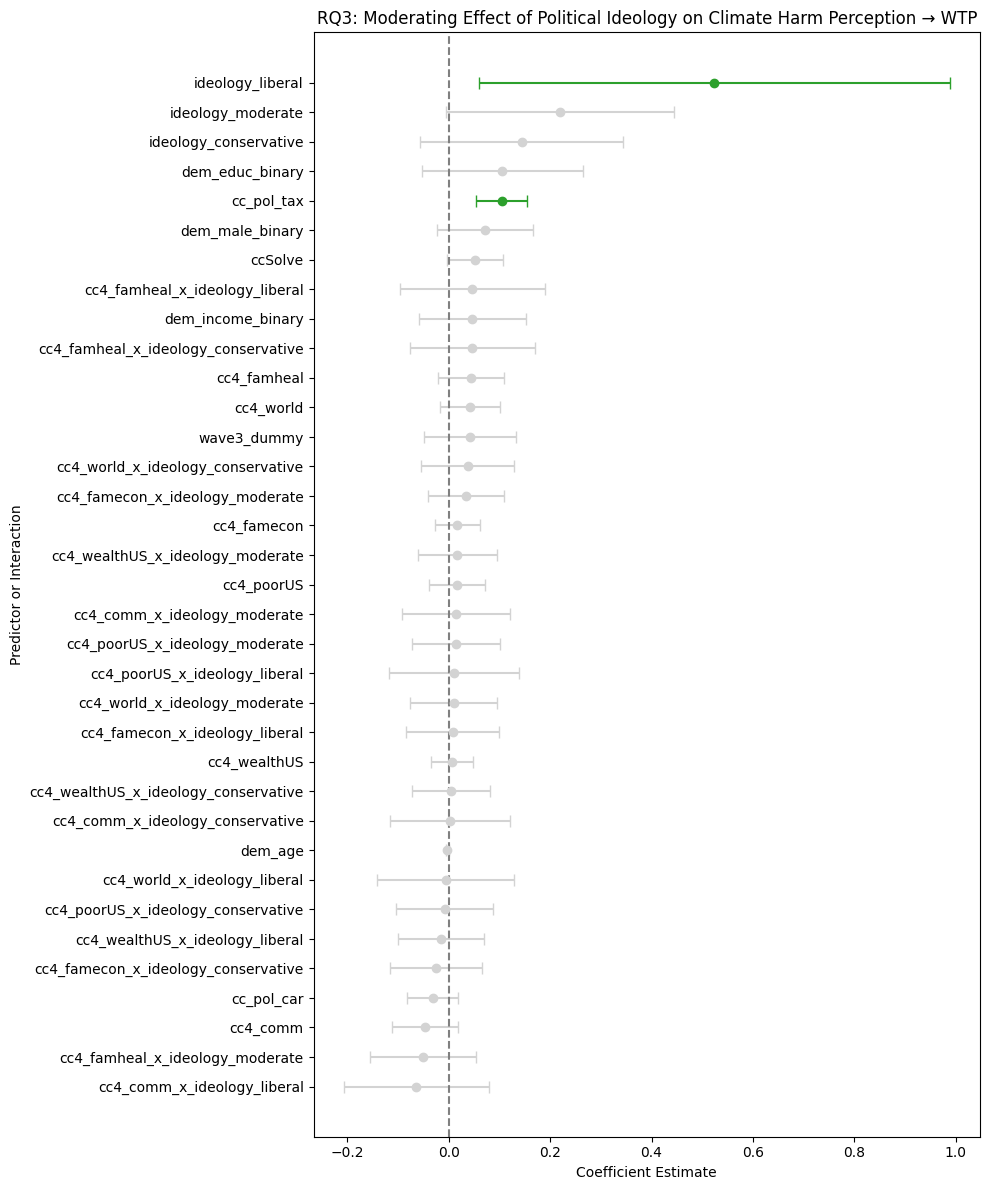

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import os
os.makedirs("../results", exist_ok=True)

# --- Helper function for RQ3 model
def extract_rq3_model_info(model):
    coefs = model.params
    conf = model.conf_int()
    df = pd.DataFrame({
        'predictor': coefs.index,
        'coef': coefs.values,
        'lower': conf[0].values,
        'upper': conf[1].values
    }).query("predictor != 'const'")
    
    # Add significance flag
    df['significant'] = ~((df['lower'] <= 0) & (df['upper'] >= 0))
    
    # Optional: clean up names (e.g., _lag suffix, underscore spacing)
    df['predictor'] = df['predictor'].str.replace('_lag', '', regex=False)
    df['predictor'] = df['predictor'].str.replace(':', ' × ')  # for interaction terms
    return df.sort_values(by='coef', ascending=True)

# --- Extract model info
plot_df = extract_rq3_model_info(rq3_model)

# --- Plotting
plt.figure(figsize=(10, 12))
for _, row in plot_df.iterrows():
    color = 'tab:green' if row['significant'] else 'lightgray'
    plt.errorbar(
        row['coef'],
        row['predictor'],
        xerr=[[row['coef'] - row['lower']], [row['upper'] - row['coef']]],
        fmt='o',
        color=color,
        ecolor=color,
        capsize=4
    )

plt.axvline(0, color='gray', linestyle='--')
plt.title("RQ3: Moderating Effect of Political Ideology on Climate Harm Perception → WTP")
plt.xlabel("Coefficient Estimate")
plt.ylabel("Predictor or Interaction")
plt.tight_layout()
plt.savefig("../results/rq3_dot_whisker_moderation.png", dpi=300)
plt.show()

#### Interaction Model – RQ3 (Ideology Moderates Harm → WTP)
* The **main effects of political ideology** are clear:
  * `ideology_liberal` has the **strongest positive association** with WTP and is **statistically significant**
* **None of the interaction terms** between harm perception variables (e.g., `cc4_world`, `cc4_comm`) and ideology groups are significant.
  * This suggests that **climate harm perception does not have a different impact on WTP depending on ideological alignment**
* Other control variables such as `cc_pol_tax` retain a **direct positive effect**, but **harm perception and demographic controls** remain **statistically insignificant**

> **Therefore, the answer to RQ3 is:**
>
> While political ideology is a **strong direct predictor** of willingness to pay, it does **not moderate** the effect of perceived climate harm.
> That is, **liberals, moderates, and conservatives react similarly** to perceived climate risks when it comes to financial support - what differs is their baseline support level, not the responsiveness to climate concern.


In [26]:
import plotly.graph_objects as go
import networkx as nx

# Build directed graph for RQ3 (significant effects only)
G3 = nx.DiGraph()

# Extract coefficients and CIs from rq3_model
coefs3   = rq3_model.params
conf3    = rq3_model.conf_int()
sig_mask = ~((conf3[0] <= 0) & (conf3[1] >= 0))

for pred, beta in coefs3.items():
    if pred == 'const':
        continue
    if sig_mask.loc[pred]:
        # add edge from predictor to ccSolve
        G3.add_edge(pred, 'ccSolve_t', weight=beta)

# Compute layout
pos3 = nx.spring_layout(G3, seed=42)

# Build traces
edge_x3, edge_y3 = [], []
for u, v in G3.edges():
    x0, y0 = pos3[u]
    x1, y1 = pos3[v]
    edge_x3 += [x0, x1, None]
    edge_y3 += [y0, y1, None]

edge_trace3 = go.Scatter(
    x=edge_x3, y=edge_y3,
    mode='lines',
    line=dict(color='gray', width=1),
    hoverinfo='none'
)

# Node positioning
node_x3, node_y3 = zip(*[pos3[n] for n in G3.nodes()])
node_text3      = list(G3.nodes())

# Color main vs interaction
node_colors3 = []
for n in G3.nodes():
    if '_x_' in n:            # interaction term
        node_colors3.append('purple')
    else:                     # main effect
        node_colors3.append('green')

node_trace3 = go.Scatter(
    x=node_x3, y=node_y3,
    mode='markers+text',
    marker=dict(size=30, color=node_colors3),
    text=node_text3,
    textposition='top center',
    hoverinfo='text'
)

# Assemble figure
fig3 = go.Figure(data=[edge_trace3, node_trace3])
fig3.update_layout(
    title="RQ3 VAR Graph: Moderation by Ideology → WTP",
    showlegend=False,
    hovermode='closest'
)
fig3.write_html("../results/rq3_var_graph_moderation.html")
fig3.show()